In [1]:
from pathlib import Path
import time

from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import partipy as pt
from partipy.utils import align_archetypes, compute_relative_rowwise_l2_distance
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import Gaussian
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

# TMP
from pathlib import Path
import sys
repo_root = Path("/home/pschaefer/sds-hd/sd22b002/projects/ParTIpy_paper")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
sys.modules.pop("code", None)
from code.utils.data_utils import load_ms_data
from code.utils.const import FIGURE_PATH, OUTPUT_PATH, SEED_DICT
def get_minimal_value_key(dict_input):
    return int(
        np.array(list(dict_input.keys()))[
            np.argmin(np.array(list(dict_input.values())))
        ]
    )


## set up output directory
figure_dir = Path(FIGURE_PATH) / "ms_coreset"
figure_dir.mkdir(exist_ok=True, parents=True)

output_dir = Path(OUTPUT_PATH) / "ms_coreset"
output_dir.mkdir(exist_ok=True, parents=True)

## setting up different seeds to test TODO: Change this
seed_list = SEED_DICT["xs"]

coreset_fraction_list = 1 / (np.array([2**n for n in range(0, 8)]) * (25 / 16))
coreset_fraction_arr = np.zeros(len(coreset_fraction_list) + 1)
coreset_fraction_arr[1:] = coreset_fraction_list
coreset_fraction_arr[0] = 1.0


result_df = pd.read_csv(Path(OUTPUT_PATH) / "ms_coreset" / "results.csv")
result_df

,celltype,time,min_l2_distance_to_ref,mean_gex_corr,rss,varexpl,mean_rel_l2_distance,seed,coreset_fraction,n_samples,n_dimensions,n_archetypes
0,MG,2.770481,0.000000,1.000000,116207.335938,0.684438,0.026094,383329927,1.000,9239,10,6
1,MG,2.685515,0.000000,1.000000,117517.164062,0.680881,0.202539,3324115916,1.000,9239,10,6
2,MG,3.680340,0.000000,1.000000,116826.687500,0.682756,0.111137,2811363264,1.000,9239,10,6
3,MG,4.491506,0.000000,1.000000,115945.656250,0.685149,0.042408,1884968544,1.000,9239,10,6
4,MG,3.281484,0.000000,1.000000,116438.210938,0.683811,0.082045,1859786275,1.000,9239,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,EC,0.021046,57.169117,0.870209,124370.819907,0.481855,0.357408,3376120482,0.005,2230,10,4
1076,EC,0.031885,151.120552,0.786237,169684.158310,0.293074,0.451333,2204291346,0.005,2230,10,4
1077,EC,0.033199,114.581345,0.554448,131851.203893,0.450691,0.473057,550243861,0.005,2230,10,4
1078,EC,0.031885,32.518183,0.989097,108880.361275,0.546390,0.258084,3606691181,0.005,2230,10,4


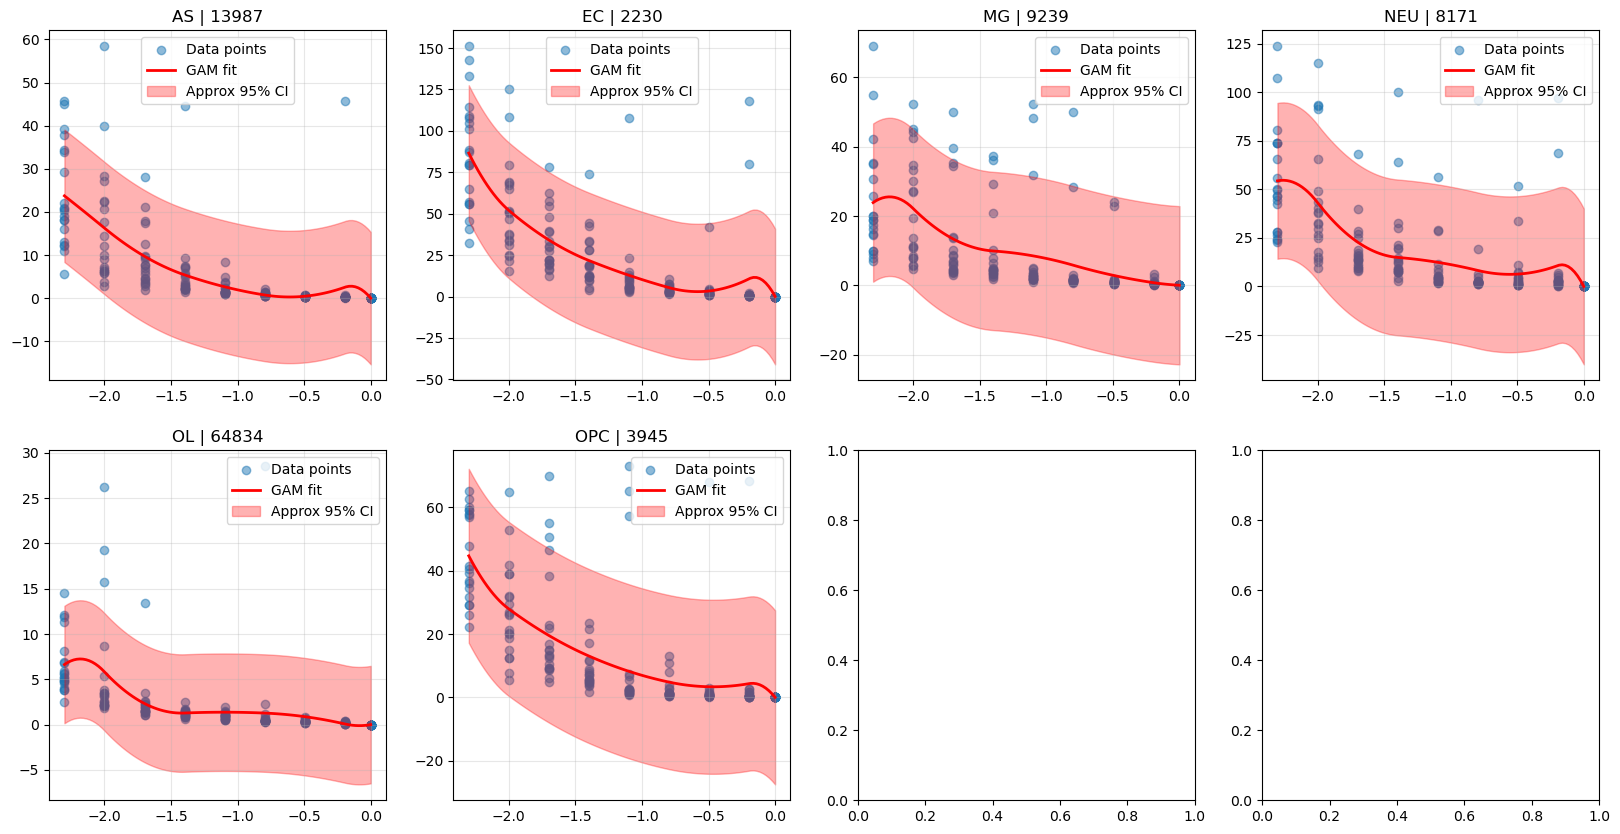

In [4]:
y_var = "min_l2_distance_to_ref"
ncols = 4
n_celltypes = result_df["celltype"].nunique()
nrows = int(np.ceil(n_celltypes / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()

for (celltype, df_group), ax in zip(result_df.groupby("celltype"), axes):
    df_group = df_group.copy()

    n_samples = df_group["n_samples"].to_numpy()[0]
    n_dimensions = df_group["n_dimensions"].to_numpy()[0]
    n_archetypes = df_group["n_archetypes"].to_numpy()[0]

    df_group["log10_coreset_fraction"] = np.log10(df_group["coreset_fraction"])
    df_group = df_group[["log10_coreset_fraction", y_var]].dropna()
    df_group = df_group.sort_values("log10_coreset_fraction")

    # extract the variables
    x = df_group["log10_coreset_fraction"].values
    y = df_group[y_var].values

    # Create B-spline basis functions
    # You can adjust the number of knots and degree as needed
    n_splines = 7  # Number of basis functions
    spline_basis = BSplines(x, df=n_splines, degree=2)

    # Add intercept term
    intercept = np.ones((len(x), 1))

    # Fit the GAM model with intercept
    gam_model = GLMGam(y, exog=intercept, smoother=spline_basis, family=Gaussian())
    gam_results = gam_model.fit()

    # Generate predictions for plotting
    x_pred = np.linspace(x.min(), x.max(), 100)

    # Create intercept for predictions
    intercept_pred = np.ones((len(x_pred), 1))

    # Get predictions using the model"s predict method
    y_pred_mean = gam_results.predict(
        exog=intercept_pred, exog_smooth=x_pred.reshape(-1, 1)
    )

    # For confidence intervals, we"ll use a simpler approach
    # Calculate standard errors manually or use bootstrap if needed
    # For now, let"s create a basic confidence interval using residual std
    residual_std = np.std(gam_results.resid_response)
    y_pred_ci = 1.96 * residual_std  # Approximate 95% CI

    # Residual analysis
    residuals = gam_results.resid_response
    fitted_values = gam_results.fittedvalues

    # Plot the results
    ax.scatter(x, y, alpha=0.5, label="Data points")
    ax.plot(x_pred, y_pred_mean, "r-", linewidth=2, label="GAM fit")
    ax.fill_between(
        x_pred,
        y_pred_mean - y_pred_ci,
        y_pred_mean + y_pred_ci,
        alpha=0.3,
        color="red",
        label="Approx 95% CI",
    )
    ax.set_title(f"{celltype} | {n_samples}")
    ax.legend()
    ax.grid(True, alpha=0.3)

#fig.savefig(figure_dir / "time_vs_coreset_fraction_gam.png")
plt.show()
plt.close()

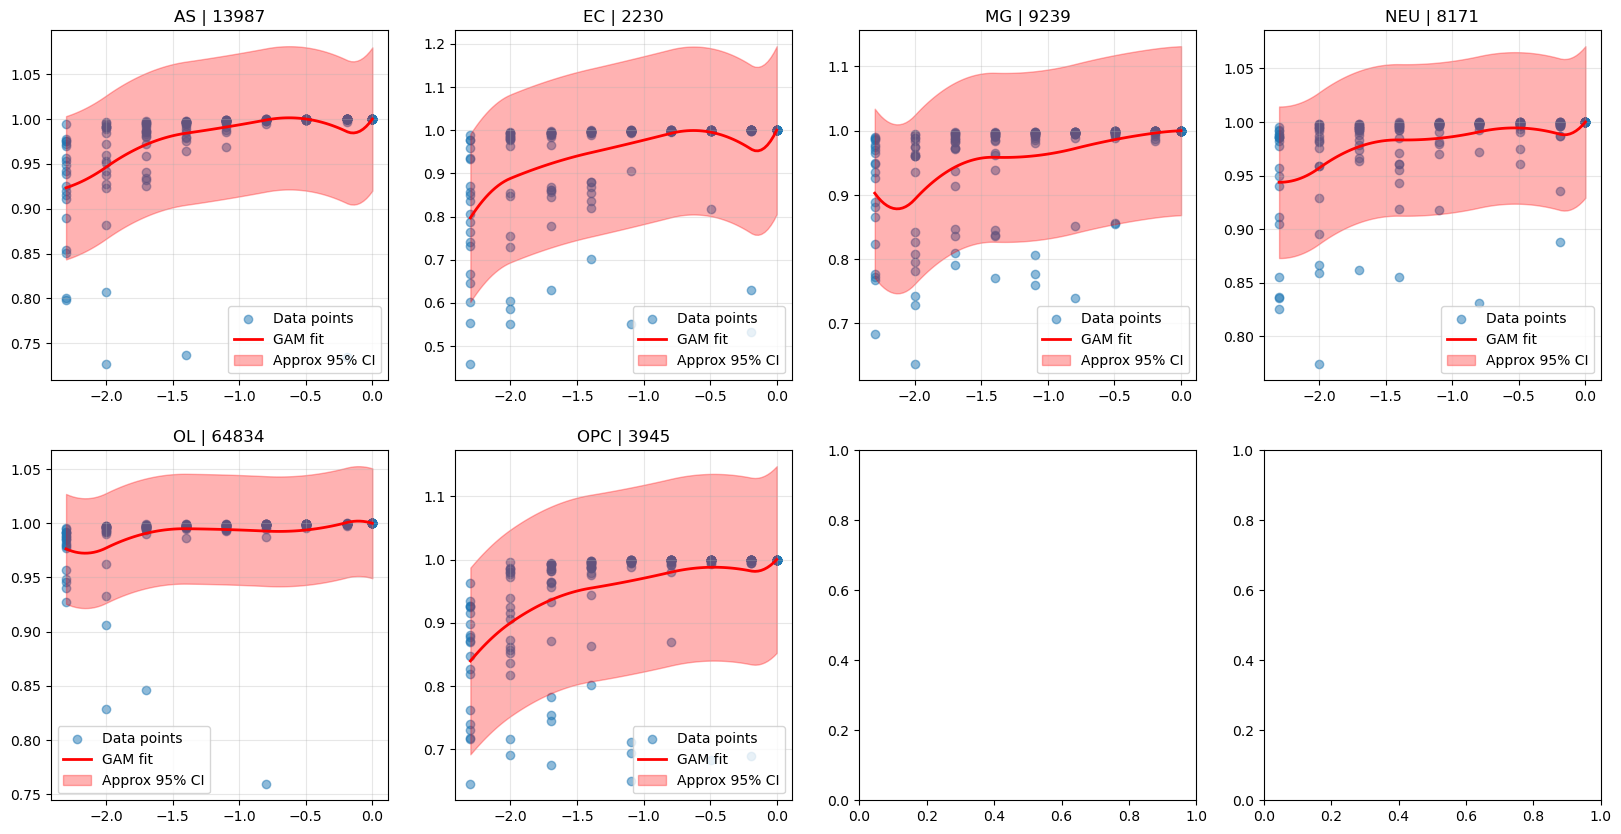

In [5]:
y_var = "mean_gex_corr"
ncols = 4
n_celltypes = result_df["celltype"].nunique()
nrows = int(np.ceil(n_celltypes / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()

for (celltype, df_group), ax in zip(result_df.groupby("celltype"), axes):
    df_group = df_group.copy()

    n_samples = df_group["n_samples"].to_numpy()[0]
    n_dimensions = df_group["n_dimensions"].to_numpy()[0]
    n_archetypes = df_group["n_archetypes"].to_numpy()[0]

    df_group["log10_coreset_fraction"] = np.log10(df_group["coreset_fraction"])
    df_group = df_group[["log10_coreset_fraction", y_var]].dropna()
    df_group = df_group.sort_values("log10_coreset_fraction")

    # extract the variables
    x = df_group["log10_coreset_fraction"].values
    y = df_group[y_var].values

    # Create B-spline basis functions
    # You can adjust the number of knots and degree as needed
    n_splines = 7  # Number of basis functions
    spline_basis = BSplines(x, df=n_splines, degree=2)

    # Add intercept term
    intercept = np.ones((len(x), 1))

    # Fit the GAM model with intercept
    gam_model = GLMGam(y, exog=intercept, smoother=spline_basis, family=Gaussian())
    gam_results = gam_model.fit()

    # Generate predictions for plotting
    x_pred = np.linspace(x.min(), x.max(), 100)

    # Create intercept for predictions
    intercept_pred = np.ones((len(x_pred), 1))

    # Get predictions using the model"s predict method
    y_pred_mean = gam_results.predict(
        exog=intercept_pred, exog_smooth=x_pred.reshape(-1, 1)
    )

    # For confidence intervals, we"ll use a simpler approach
    # Calculate standard errors manually or use bootstrap if needed
    # For now, let"s create a basic confidence interval using residual std
    residual_std = np.std(gam_results.resid_response)
    y_pred_ci = 1.96 * residual_std  # Approximate 95% CI

    # Residual analysis
    residuals = gam_results.resid_response
    fitted_values = gam_results.fittedvalues

    # Plot the results
    ax.scatter(x, y, alpha=0.5, label="Data points")
    ax.plot(x_pred, y_pred_mean, "r-", linewidth=2, label="GAM fit")
    ax.fill_between(
        x_pred,
        y_pred_mean - y_pred_ci,
        y_pred_mean + y_pred_ci,
        alpha=0.3,
        color="red",
        label="Approx 95% CI",
    )
    ax.set_title(f"{celltype} | {n_samples}")
    ax.legend()
    ax.grid(True, alpha=0.3)

#fig.savefig(figure_dir / "time_vs_coreset_fraction_gam.png")
plt.show()
plt.close()